### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
# from src.RetFound import get_retfound
from src.FocalLoss import FocalLoss
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (224,224)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'final_edema'
TEST_SIZE = 0.2
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN =  [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 3

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


patient  age  sex  dm_time  insulin  insulin_time  oraltreatment_dm  \
0        1   58    1     15.0      1.0           NaN               1.0   
1        1   58    1     15.0      1.0           NaN               1.0   
2        1   58    1     15.0      1.0           NaN               1.0   
3        1   58    1     15.0      1.0           NaN               1.0   
4       10   63    0      7.0      0.0           NaN               1.0   

   systemic_hypertension  insurance  educational_level  ...  nephropathy  \
0                    1.0        0.0                3.0  ...          1.0   
1                    1.0        0.0                3.0  ...          1.0   
2                    1.0        0.0                3.0  ...          1.0   
3                    1.0        0.0                3.0  ...          1.0   
4                    1.0        0.0                2.0  ...          0.0   

   neuropathy  diabetic_foot      file  laterality  final_artifacts  \
0         0.0            0.0   1.1.jpg       right              yes   
1         0.0            0.0   1.2.jpg       right              yes   
2         0.0            0.0   1.3.jpg        left              yes   
3         0.0            0.0   1.4.jpg        left              yes   
4         0.0            0.0  10.1.jpg       right              yes   

   final_quality  final_icdr final_edema normality  
0            yes         4.0          no  abnormal  
1            yes         4.0          no  abnormal  
2            yes         4.0          no  abnormal  
3            yes         4.0          no  abnormal  
4            yes         0.0          no  abnormal  

[5 rows x 25 columns]

In [4]:

df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 'no' else ('Edema'))

Train data shape: (4130, 25)
Test data shape: (1033, 25)


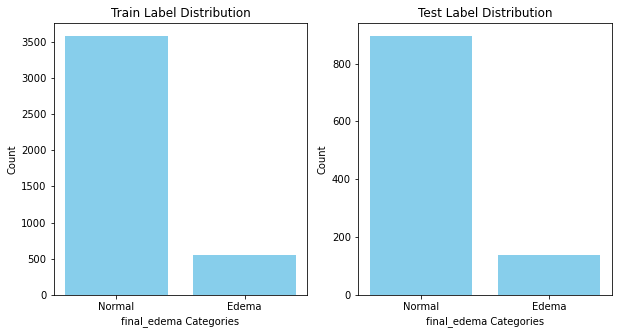

Getting validation set...


In [6]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_val = df_test

### Dataloaders

In [7]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [8]:
# Define the target image shape

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [9]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [10]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


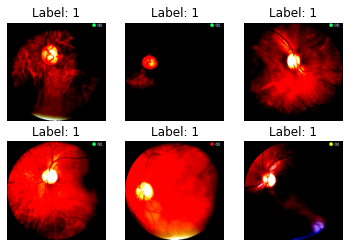

In [11]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:

    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()
    break

### Model

In [12]:
# Create a DataLoader to generate embeddings
#model = get_retfound(weights='/scratch/liyues_root/liyues/chenweiw/retina_datasets/retfound_weigths/RETFound_cfp_weights.pth', num_classes=3)
# Create a DataLoader to generate embeddings
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [13]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [ 554 3576]


In [14]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'{BACKBONE}_{num_classes}class_{LABEL}')

100%|██████████| 65/65 [00:13<00:00,  4.98it/s]


Epoch 1, Train Loss: 0.026839240202428522, Val Loss: 0.021406167960510803, F1 Score: 0.7932626422979335, acc0.8857696030977735
cm[[112  26]
 [ 92 803]]


100%|██████████| 65/65 [00:13<00:00,  4.80it/s]


Epoch 2, Train Loss: 0.017261145640934124, Val Loss: 0.020745264541787597, F1 Score: 0.8146625438998321, acc0.9090029041626331
cm[[101  37]
 [ 57 838]]


100%|██████████| 65/65 [00:13<00:00,  4.97it/s]


Epoch 3, Train Loss: 0.009417707691014956, Val Loss: 0.021583047383823075, F1 Score: 0.7833408239700375, acc0.8712487899322362
cm[[121  17]
 [116 779]]


100%|██████████| 65/65 [00:13<00:00,  4.88it/s]


Epoch 4, Train Loss: 0.003331439781578484, Val Loss: 0.06832340159945978, F1 Score: 0.82565317954801, acc0.9312681510164569
cm[[ 79  59]
 [ 12 883]]


100%|██████████| 65/65 [00:12<00:00,  5.06it/s]


Epoch 5, Train Loss: 0.0013005999437109318, Val Loss: 0.04001582555938512, F1 Score: 0.7481286421378588, acc0.8451113262342691
cm[[116  22]
 [138 757]]


100%|██████████| 65/65 [00:13<00:00,  4.84it/s]


Epoch 6, Train Loss: 0.003000073546110138, Val Loss: 0.04979630262219311, F1 Score: 0.821724785543881, acc0.9177153920619555
cm[[ 95  43]
 [ 42 853]]


100%|██████████| 65/65 [00:13<00:00,  4.83it/s]


Epoch 7, Train Loss: 0.0006477378307317498, Val Loss: 0.06311673122506294, F1 Score: 0.8187719298245615, acc0.9186834462729913
cm[[ 91  47]
 [ 37 858]]


100%|██████████| 65/65 [00:12<00:00,  5.08it/s]


Epoch 8, Train Loss: 0.0001954543608043946, Val Loss: 0.07509016111953315, F1 Score: 0.8284053156146179, acc0.9244917715392061
cm[[ 91  47]
 [ 31 864]]


100%|██████████| 65/65 [00:12<00:00,  5.11it/s]


Epoch 9, Train Loss: 3.933928119681432e-05, Val Loss: 0.08217870287150547, F1 Score: 0.8272664128421485, acc0.9244917715392061
cm[[ 90  48]
 [ 30 865]]


100%|██████████| 65/65 [00:12<00:00,  5.12it/s]


Epoch 10, Train Loss: 2.410688359566525e-05, Val Loss: 0.08939774305437227, F1 Score: 0.8305680248618785, acc0.9264278799612778
cm[[ 90  48]
 [ 28 867]]


100%|██████████| 65/65 [00:13<00:00,  4.81it/s]


Epoch 11, Train Loss: 1.6585715645786837e-05, Val Loss: 0.09352861707541252, F1 Score: 0.8265905657210004, acc0.925459825750242
cm[[ 88  50]
 [ 27 868]]


100%|██████████| 65/65 [00:13<00:00,  4.81it/s]


Epoch 12, Train Loss: 1.2080593351603271e-05, Val Loss: 0.0965939308883776, F1 Score: 0.8265905657210004, acc0.925459825750242
cm[[ 88  50]
 [ 27 868]]


100%|██████████| 65/65 [00:12<00:00,  5.08it/s]


Epoch 13, Train Loss: 9.319719091918054e-06, Val Loss: 0.09884458546449389, F1 Score: 0.8265905657210004, acc0.925459825750242
cm[[ 88  50]
 [ 27 868]]


100%|██████████| 65/65 [00:13<00:00,  4.80it/s]


Epoch 14, Train Loss: 7.161137304424002e-06, Val Loss: 0.1017490801536986, F1 Score: 0.8294223983591456, acc0.9264278799612778
cm[[ 89  49]
 [ 27 868]]


100%|██████████| 65/65 [00:13<00:00,  4.86it/s]


Epoch 15, Train Loss: 5.715322862848942e-06, Val Loss: 0.1057778233399666, F1 Score: 0.8294223983591456, acc0.9264278799612778
cm[[ 89  49]
 [ 27 868]]


100%|██████████| 65/65 [00:13<00:00,  4.78it/s]


Epoch 16, Train Loss: 4.629442821931514e-06, Val Loss: 0.10814810679907466, F1 Score: 0.8294223983591456, acc0.9264278799612778
cm[[ 89  49]
 [ 27 868]]


100%|██████████| 65/65 [00:13<00:00,  4.76it/s]


Epoch 17, Train Loss: 3.880389445893673e-06, Val Loss: 0.1101353742516529, F1 Score: 0.8294223983591456, acc0.9264278799612778
cm[[ 89  49]
 [ 27 868]]
Early stopping triggered.


### Test

100%|██████████| 65/65 [00:13<00:00,  4.92it/s]


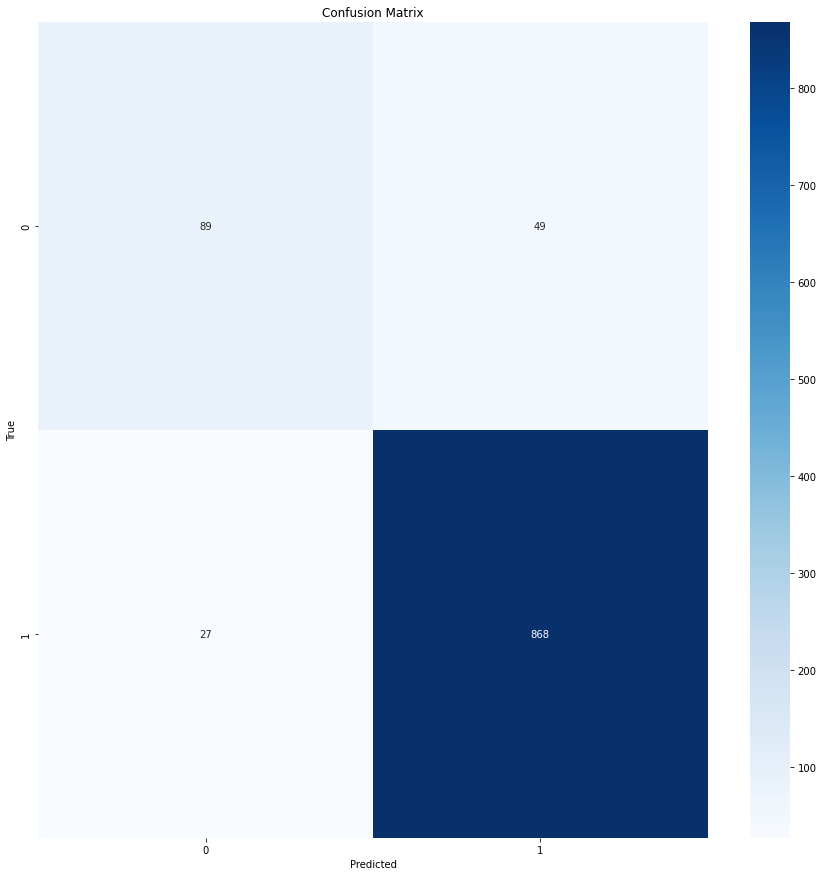

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.77      0.64      0.70       138
           1       0.95      0.97      0.96       895

    accuracy                           0.93      1033
   macro avg       0.86      0.81      0.83      1033
weighted avg       0.92      0.93      0.92      1033

##################################################  Saliency Maps  ##################################################

Class 0:


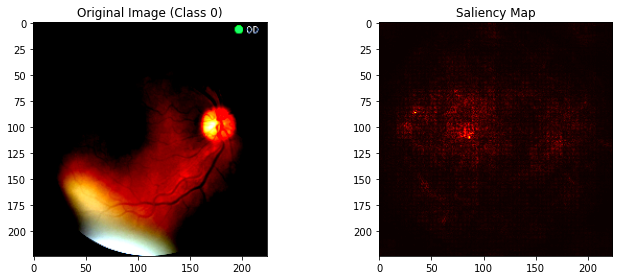

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


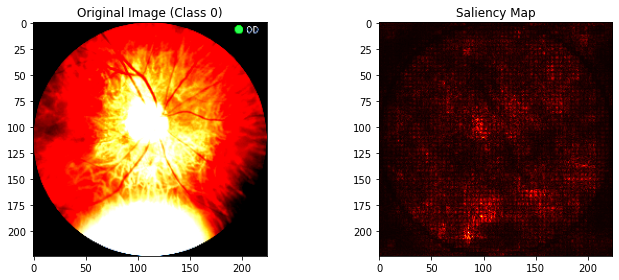

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


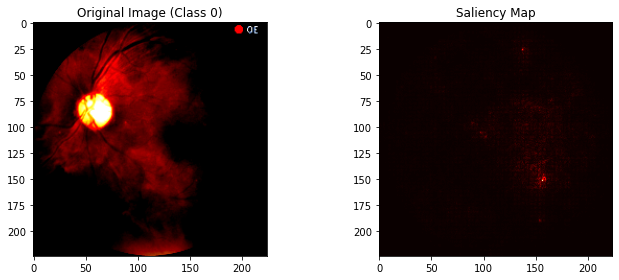

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


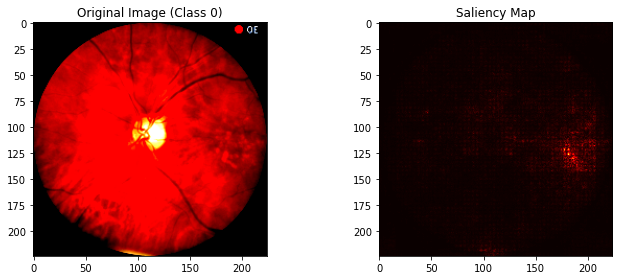

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


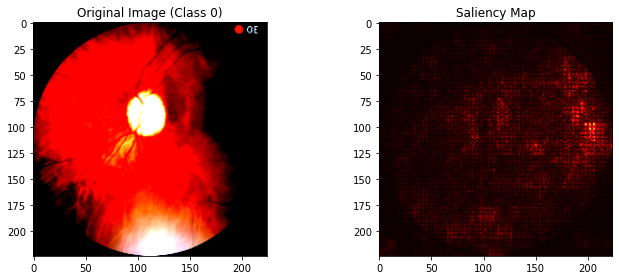

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


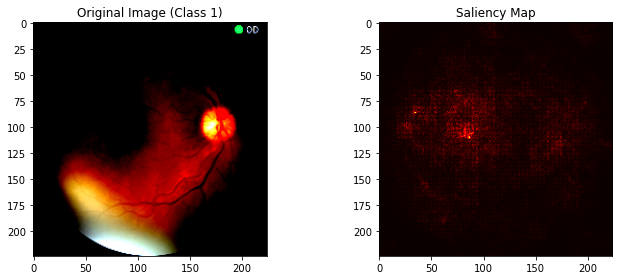

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


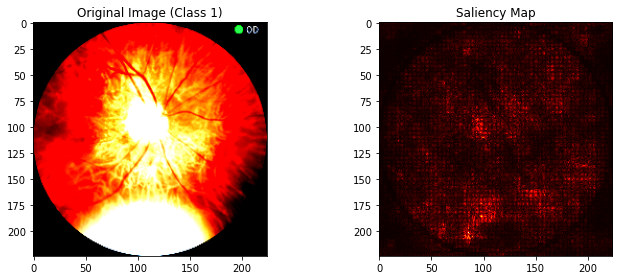

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


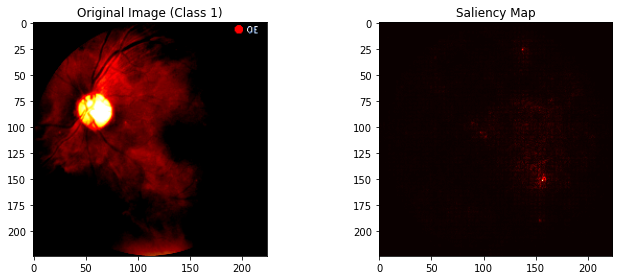

In [ ]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [15]:
# Good quality images
adequate_df = df_test[df_test['final_quality'] == 'yes']

# Bad quality images
inadequate_df = df_test[df_test['final_quality'] == 'no']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 73/73 [00:15<00:00,  4.64it/s]


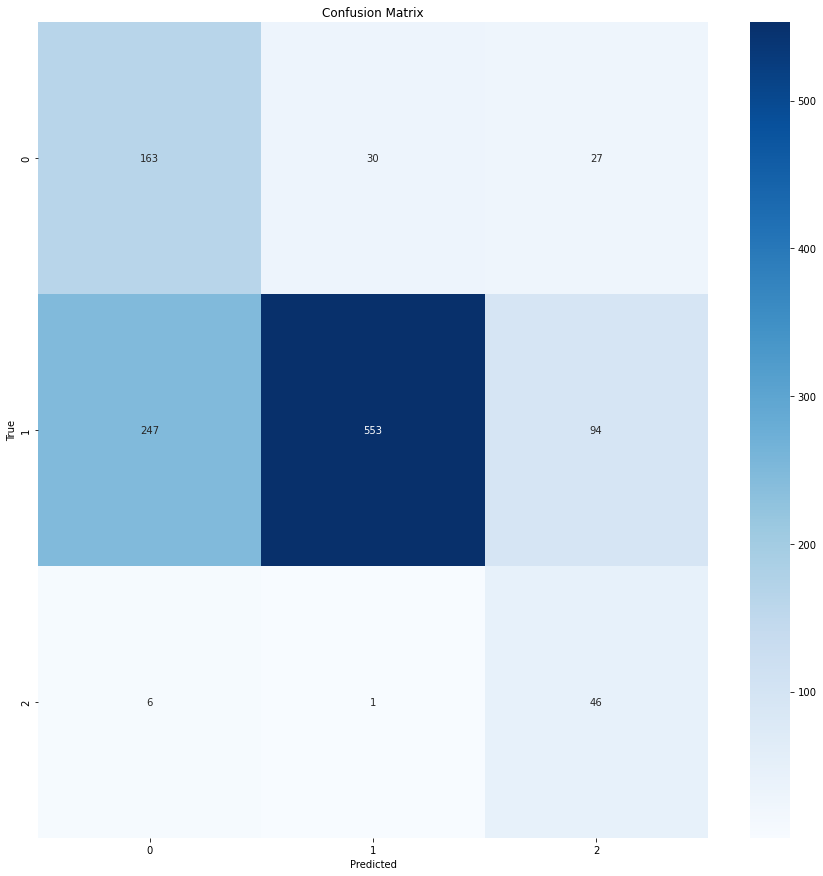

              precision    recall  f1-score   support

           0       0.39      0.74      0.51       220
           1       0.95      0.62      0.75       894
           2       0.28      0.87      0.42        53

    accuracy                           0.65      1167
   macro avg       0.54      0.74      0.56      1167
weighted avg       0.81      0.65      0.69      1167

##################################################  Saliency Maps  ##################################################

Class 0:


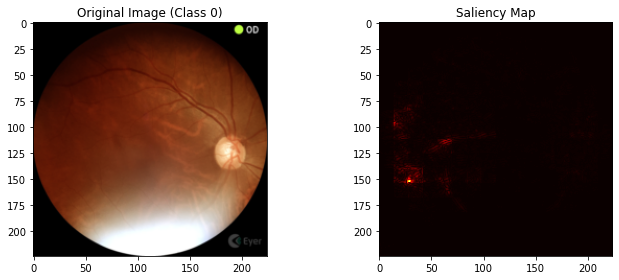

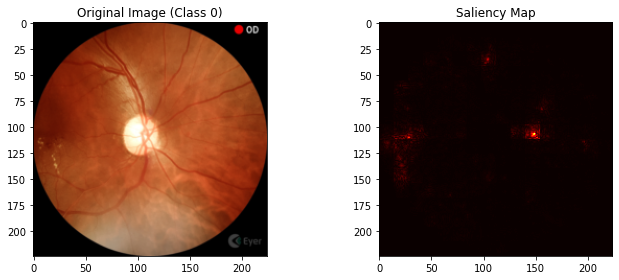

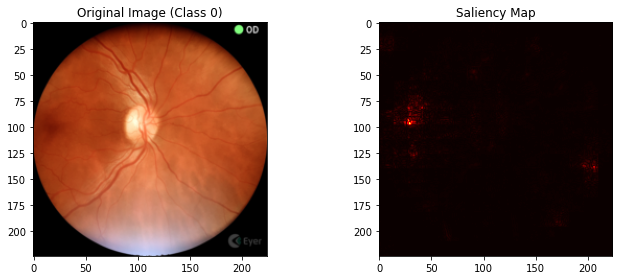

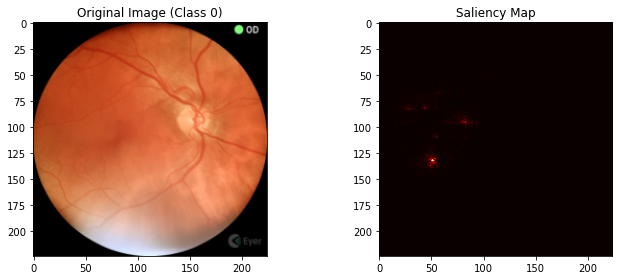

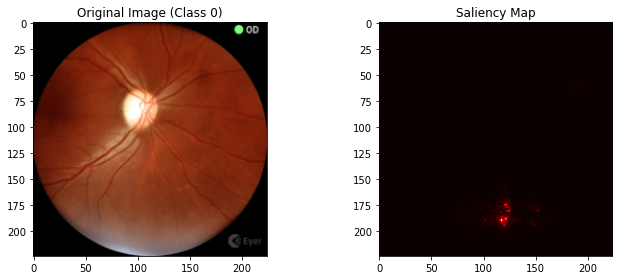

Class 1:


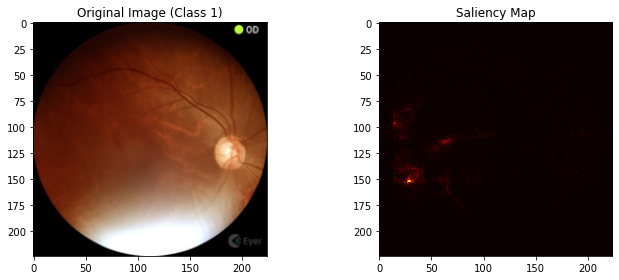

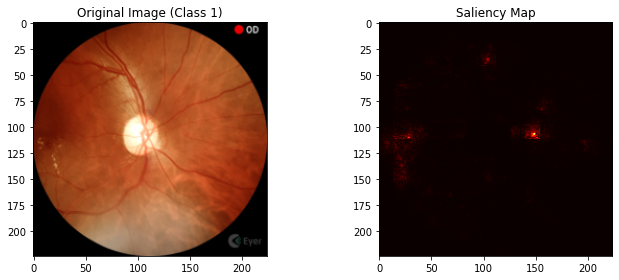

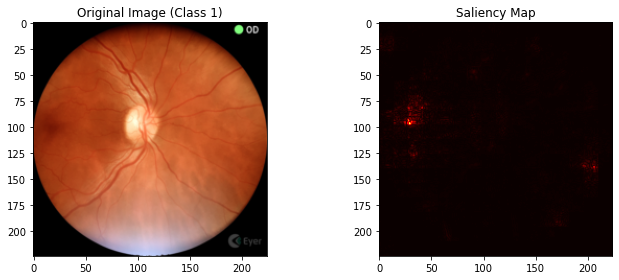

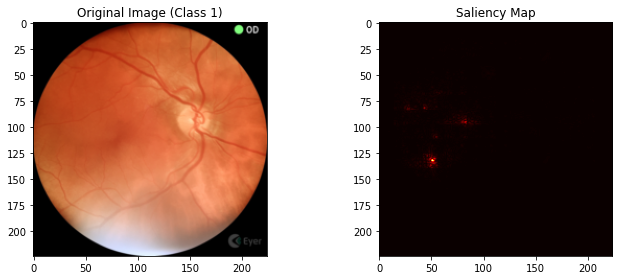

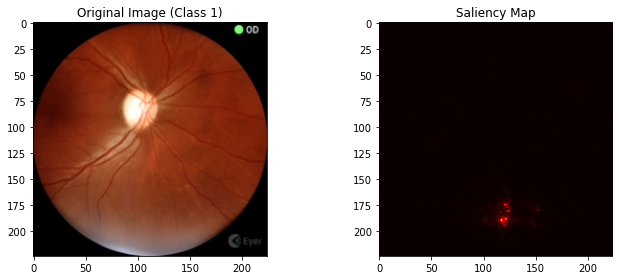

Class 2:


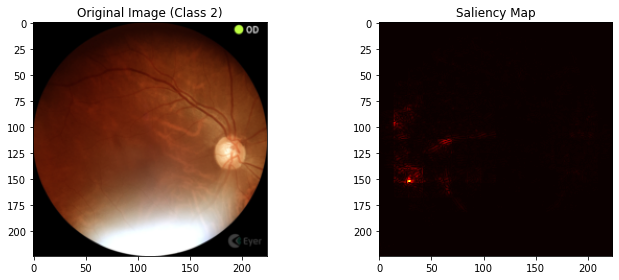

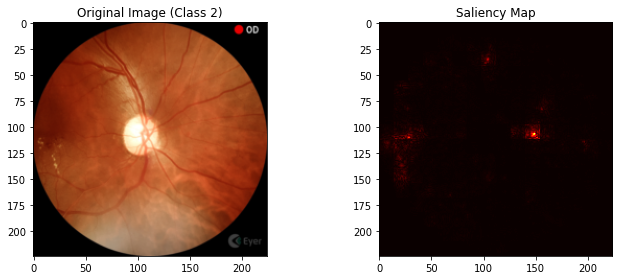

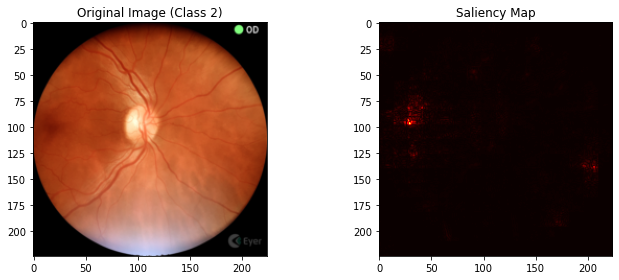

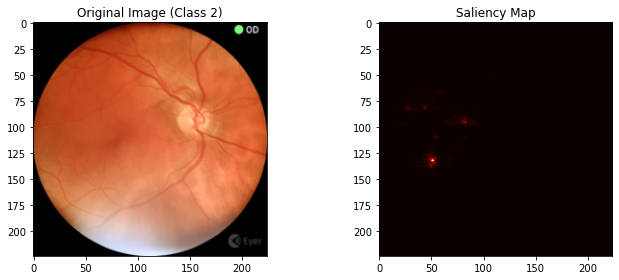

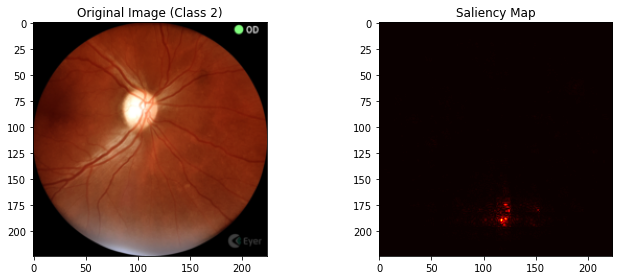

In [16]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


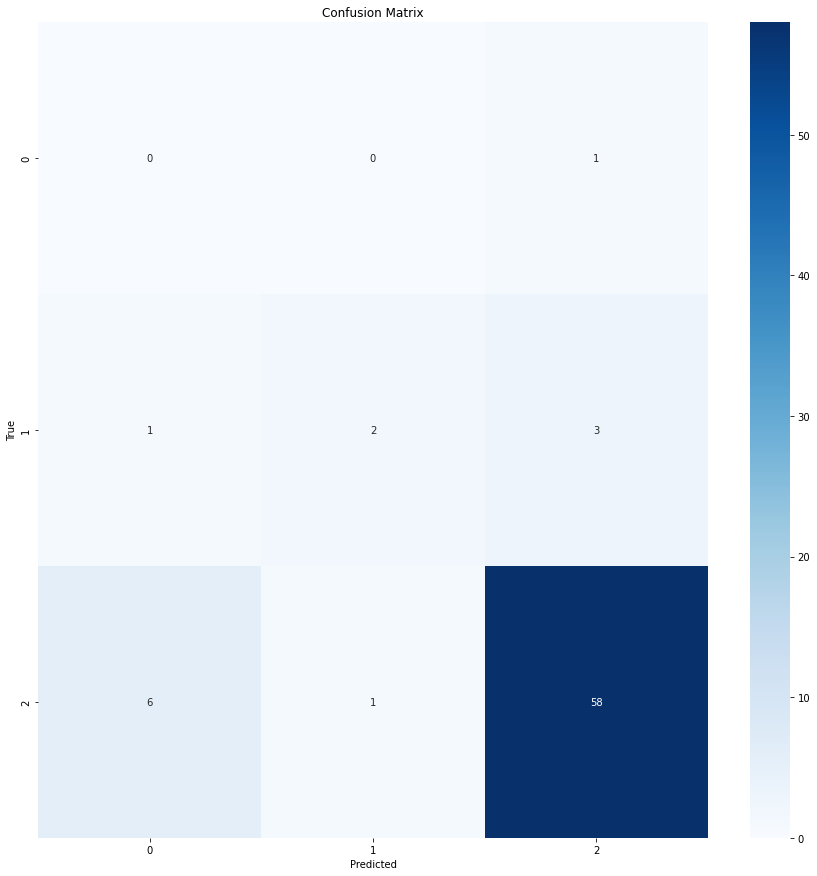

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.33      0.44         6
           2       0.94      0.89      0.91        65

    accuracy                           0.83        72
   macro avg       0.53      0.41      0.45        72
weighted avg       0.90      0.83      0.86        72

##################################################  Saliency Maps  ##################################################

Class 0:


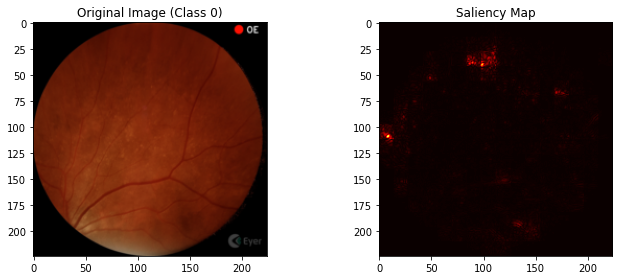

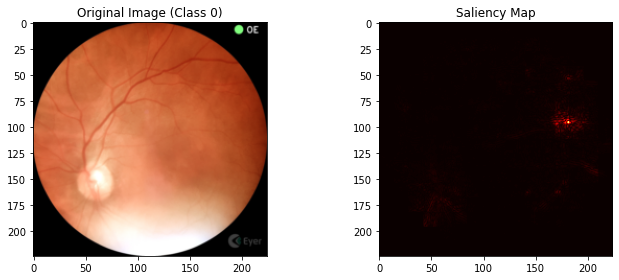

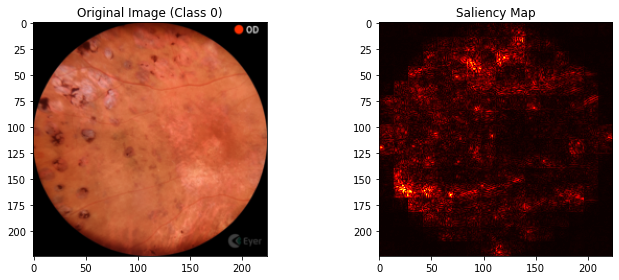

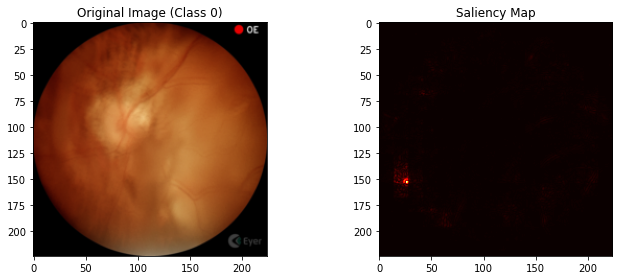

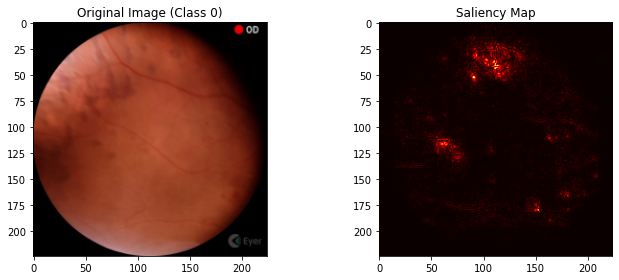

Class 1:


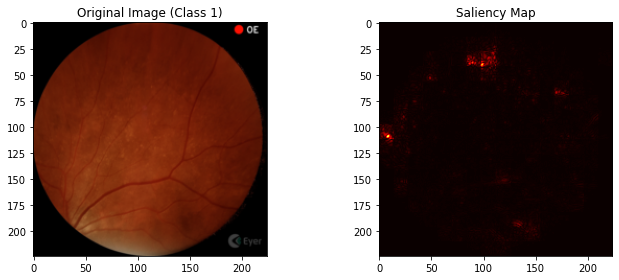

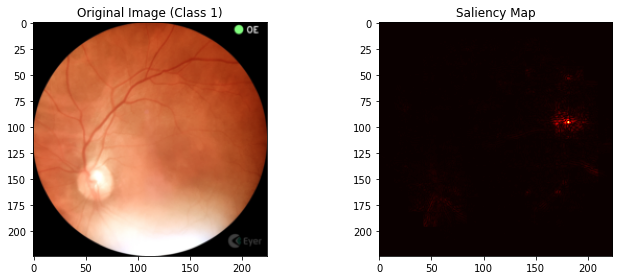

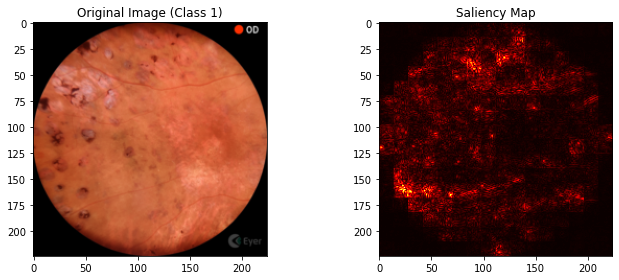

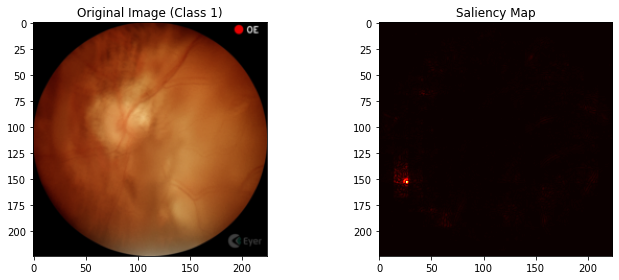

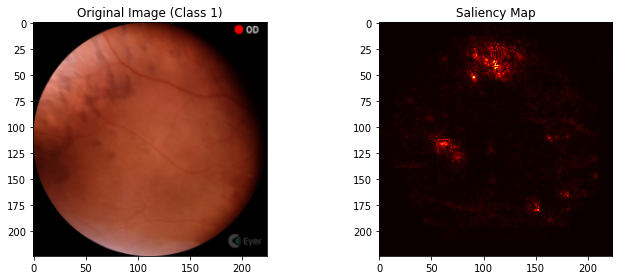

Class 2:


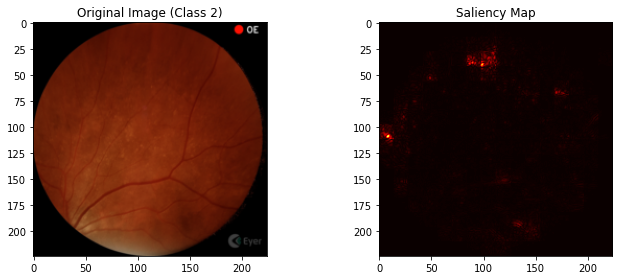

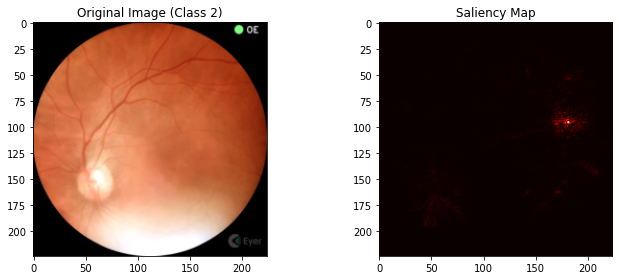

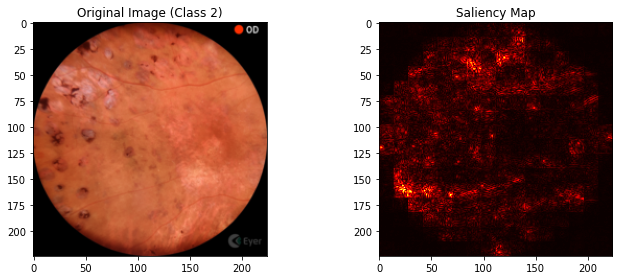

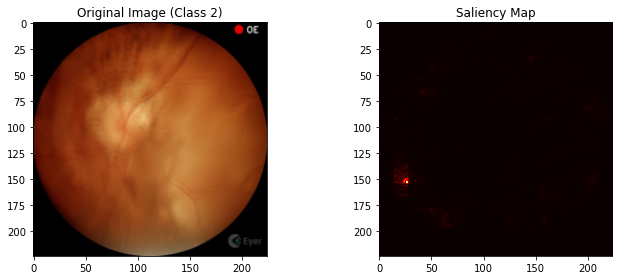

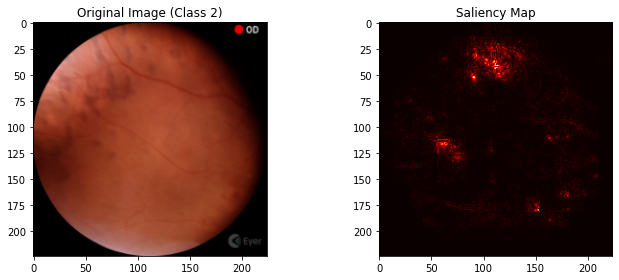

In [17]:
test(model, inadequate_dataloader, saliency=True, device=device)